# Visualize competitive qpAdm Models

In [2]:
import numpy as np
import os  # For Saving to Folder
import pandas as pd
import matplotlib.pyplot as plt

import socket
import os as os
import sys as sys
import multiprocessing as mp
import itertools as it
from time import time
from matplotlib import gridspec

# For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
# Make sure to have the font installed (it is on cluster for Harald)
rcParams['font.sans-serif'] = ['Arial']

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/punic_aDNA/"  # The Path on HMS Cluster
else:
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
# Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")
print(sys.version)

compute-a-16-162.o2.rc.hms.harvard.edu
HSM Computational partition detected.
/n/groups/reich/hringbauer/git/punic_aDNA
CPU Count: 32
3.7.4 (default, Sep 11 2019, 11:24:51) 
[GCC 6.2.0]


In [70]:
###################################################
###################################################
### Define Plot functions

def fig_admix(axes=[], res=[], p_vals=[], target_pops=[], 
              source_pops=[], figsize=(12,8), 
              save_path="", lw=2,
              pval_lim=[1e-6,1.0], stds=[], 
              l_pos = (1, 0.5), fs = 12, bw = 0.85, 
              c=[], ec = "white", show=False,
              height_ratios=[1, 8],
              rotation=90, legend=True):
    """Plot a Figure of the admixture coefficients.
    axes: 2 axis where to plot Fractions and p-Values onto
    res: nxk Array of Results
    p_vals: Array of p-Vals [n]
    target_pops: String Array of Target Pops [n]
    source_pops: String Array of Source Pops [k]
    stds: Standard Errors. If none are given do not plot them
    l_pos: Where to place the Legend.
    lw: Linewidth of bar"""
    # Create Pandas Dataframe for Plot
    #pd.DataFrame(data=target_pops, index=r, columns=source_pops)
    
    ### Define Axes if not given
    if len(axes)==0:
        fig, axes = plt.subplots(nrows=2, ncols=1,
                                 gridspec_kw={'height_ratios': height_ratios}, 
                                 figsize=figsize)
    ax0, ax1 = axes
    
    # Plot Parameters
    r = np.arange(len(target_pops))
    barWidth = bw
    if len(c)==0:
        c=["DeepPink", "MediumBlue", "purple", "yellowgreen", "gold"]
    
    for i, s in reversed(list(enumerate(source_pops))): # From last to first (For Legend)
        s = source_pops[i]
        b = np.sum(res[:,:i], axis=1)
        ax1.bar(r, res[:,i], bottom=b, color=c[i], edgecolor=ec, width=barWidth, label=s, alpha=0.9)
        
        if len(stds)>0: # Plot some standard deviations.
            ax1.errorbar(r, b+res[:,i], yerr=stds[:,i], fmt='none', linewidth=lw, color="k")
    
    ### Add the Model not viable bars:
    su = np.sum(res, axis=1)
    sum0ids = np.where(su==0)[0]
    
    for i in sum0ids:
        ax1.bar(i, 1, color="lightgray", edgecolor='white', width=barWidth, alpha=0.9)
     
    ################
    # Custom x axis
    ax1.set_xticks(r)
    ax1.set_xticklabels(target_pops, fontsize=fs, rotation=rotation)

    # Add a legend
    #l1 = ax1.legend(loc=l_pos, bbox_to_anchor=(1, 0.5), ncol=1, fontsize=fs)
    if legend:
        l1 = ax1.legend(bbox_to_anchor=l_pos, ncol=1, fontsize=fs)
        l1.set_title('Sources: ', prop={'size':fs})
    
    ax1.set_ylabel("Fraction Ancestry", fontsize=fs*1.5)
    ax1.set_ylim([0,1])
    ax1.set_xlim([-0.6, len(target_pops)-0.4])
    
    ax0.set_yscale("log")
    ax0.set_ylim(pval_lim)
    ax0.bar(r, p_vals, color="grey", width=barWidth, alpha=0.8, zorder=1)
    ax0.axhline(y=0.05, color='r', zorder=0)
    ax0.set_ylabel("p-Val", fontsize=fs)
    ax0.set_xlim([-0.6,len(target_pops)-0.4])
    ax0.set_xticks([])
    
    # Adjust position of subplots
    #plt.subplots_adjust(left=0, bottom=0.05, right=None,
    #            wspace=0, hspace=0.06)
    
    if len(save_path) > 0:
        plt.savefig(save_path, bbox_inches = 'tight', pad_inches = 0)
        print("Saved to %s" % save_path)
        # Save the .csv of the Results
    
    if show:
        plt.show()
        
def plot_qpadm(dir_path, test_pops, save_path="", l_pos = (0.4, 1.15), 
               best=True, figsize=(12,8), bw = 0.85, lw=2,
               height_ratios = [1,8],
               c=[], ec="white", fs=10, pval_lim = [1e-3,1],
               latex=False, dataframe=False):
    """Do 3 Way Admixtures of Sardinia
    best: Whether to use highest p-Val Submodel: 0 use the first, 
    True use the best p-Value, 
    else use the old (first feasible)"""
    admix_coeffs = []
    p_vals = []
    pops_t = [] 
    stds = []
    pr = False # Print the statistics

    #for filename in os.listdir(dir_path):
    for f in test_pops:
        full_path = dir_path + str(f) + ".log" # Other "outputMycSicily_"
        res, p_val_ls, pops, std = load_qp_adm(full_path)

        pops_t.append(pops[0])
        
        if best == 0:
            i = give_admix0(res)   # Give the first result (if feasible)
            
        elif best == True:
            i = give_admix_index_best(res, p_val_ls) # Give the best feasible p-Value
        
        else:
            i = give_admix_index(res)
            
        #### Handle Not fitting Models  
        if np.isnan(i): # In Case no valid admixture:
            new_res = np.zeros(np.shape(res)[1]) # Not Plot anything
            std = np.zeros(np.shape(res)[1])     # Not Plot anything
            new_p = -1 # For Sorting
        
        else:
            new_res = res[i,:]
            new_p = p_val_ls[i]
        
        admix_coeffs.append(new_res)
        p_vals.append(new_p)
        stds.append(std)

        if pr == True:
            print("Population: %s" % f)
            print(res[i,:])
            print(std)
            print(p_val_ls[i])

    admix_coeffs, stds = np.array(admix_coeffs), np.array(stds)
    source_pops = pops[1:]
    
    fig_admix(res=admix_coeffs, 
              p_vals=p_vals, 
              target_pops=pops_t, 
              source_pops=source_pops, 
              pval_lim=pval_lim, 
              stds=stds, save_path = save_path, 
              l_pos = l_pos, lw=lw,
              height_ratios=height_ratios,
              fs=fs, figsize=figsize, 
              bw = bw, c=c, ec = ec)
    
    if latex:
        source_pops = [([t] + pops[1:]) for t in pops_t]
        create_latex_lines(source_pops, admix_coeffs, stds, 
                           p_vals, na = "-", rp = "A15")
        
    if dataframe:
        source_pops = np.array([([t] + pops[1:]) for t in pops_t])
        df = create_admix_df(source_pops, admix_coeffs, stds, p_vals)
        return(df)
    
    
def plot_qpadm_split(dfs, sources=[], figsize=(12,8), labels=[],
                     bw = 0.85, lw=2,
                     c=[], ec="white", fs=10, 
                     height_ratios=[1, 10], wspace=0.05, hspace=0.05,
                     pval_lim = [1e-3, 1], pr=False, save_path="", 
                     leg_pos=1,legend=True, l_pos=(1, 0.5)):
    """Do 3 Way Admixtures of Sardinia
    best: Whether to use highest p-Val Submodel: 0 use the first, True use the best p-Value, 
    else use the old (first feasible)
    test_pops: List of lists: Will be split up into subdataframes
    pr: whether to print output"""
    
    ### Prepare the Full Figure Layout
    fig = plt.figure(figsize=figsize)
    
    width_ratios = list(map(len, dfs))
    gs = gridspec.GridSpec(2, len(dfs), 
                           width_ratios = width_ratios, 
                           height_ratios = height_ratios, 
                           figure = fig)
    
    gs.update(wspace=wspace, hspace=hspace) # set the spacing between axes
    
    ### Iterate over all Populations
    k = len(sources)
    
    for j, df in enumerate(dfs):   
        ######################
        ### Load the Data
        admix_coeffs = df[[f"f{i}" for i in range(1,k+1)]].values
        stds = df[[f"std{i}" for i in range(1,k+1)]].values
        p_vals = df["p"].values
        pops_t = df["t"].values 
        
        ######################
        ### Do the actual Plot
        ax_adm = fig.add_subplot(gs[0, j])
        ax_p = fig.add_subplot(gs[1, j])
        
        if j>0:
            legend=False
            
        fig_admix(axes=[ax_adm, ax_p], res=admix_coeffs, 
                  p_vals=p_vals, target_pops=pops_t, 
                  source_pops=sources, pval_lim=pval_lim, 
                  stds=stds, save_path = "", 
                  lw=lw, fs=fs, figsize=figsize, 
                  bw = bw, c=c, ec = ec, show=False,
                  legend=legend, l_pos = l_pos)
        
        ### Turn off the Labels for all but first plot
        if j>0:
            for ax in [ax_p, ax_adm]:
                ax.set_yticklabels([])
                ax.set_ylabel("")
                
        if len(labels)>0:
                ax_adm.set_title(labels[j], fontsize=fs)
            
    if len(save_path) > 0:
        plt.savefig(save_path, bbox_inches = 'tight', 
                    pad_inches = 0)
        print("Saved to %s" % save_path)
        # Save the .csv of the Results
    plt.show()
    
### Helper Function
def set_feasible_df(df, sources=5):
    """Set Feasible Models"""
    
    fs = [f"f{i}" for i in range(1,sources+1)]

    idx_if = np.nanmin(df[fs], axis=1) < 0
    df["fs"] = True
    if np.sum(idx_if)>0: # Reset Values if infeasible idx
        df.loc[idx_if, "fs"] = False
    
    print(f"Set {np.sum(idx_if)}/{len(idx_if)} infeasible models")
    return df

def get_spec_model(df, sources=[], tot_sources=5, 
                   drop=True, output=True):
    """Get specific model for dataframe df.
    Return dataframe with this model."""
    k = len(sources)
    found = np.ones(len(df), dtype="bool")
    for i in range(1,k+1):
        idx = df[f"s{i}"].isin(sources)
        found = found & idx
    for i in range(k+1, tot_sources+1): 
        idx = df[f"s{i}"].isnull()
        found = found & idx
        
    if output: 
        print(f"Found {np.sum(found)} fitting rows.")
    dft = df[found]
    
    ### Drop Unnecessary Labels
    if drop:
        for i in range(k+1, tot_sources+1):
            dft = dft.drop(columns=[f"s{i}", f"f{i}", f"std{i}"])
    
    return dft.reset_index(drop=True).copy()

def df_excl_source(df, exclude=[], tot_sources=5, 
                     output=True):
    """Return dataframe with specific sources excluded."""
    k = len(sources)
    
    found = np.ones(len(df), dtype="bool")
    for i in range(1, tot_sources+1):
        idx = df[f"s{i}"].isin(exclude)
        found = found & ~idx
        
    if output: 
        print(f"Found {np.sum(found)}/{len(found)} models without {exclude}.")
    dft = df[found]
    return dft.reset_index(drop=True).copy()   

def get_individual_models(df, min_p=0.01, feasible=True, best_p=False):
    """Get Dataframe with rows of best Indivdidual Model
    (lowest number of sources, highest p Value).
    best_p: Whether to pick model with best p-Value"""
    #df = df.sort_values(by=["p", "n"], ascending=[False, True])
    dft = df.copy()
    
    if feasible:
        dft = dft[dft["fs"]==True]
    
    ### Option A) Simply extract the best feasible Model
    if best_p:
        dft["n"]=0 
        
    #  Option B) Rank non fitting models  as high pop size
    else:
        dft.loc[(dft["p"]< min_p), "n"] = 100
           
    ### Order all models first by pop size and then by p within
    dft = dft.sort_values(by=["n", "p"], ascending=[True, False])
    idx_dup = dft["t"].duplicated()
    dft = dft[~idx_dup]
    return dft.reset_index(drop=True).copy()

def split_up_res_df(df1, dfq):
    """Split up individual qpAdm result
    dataframe into subdataframes according to
    dfq (matching on loc and containing clst)"""
    dfq = pd.read_csv("./data/qpAdm_pops.tsv", sep="\t")

    dfs = []
    for index, row in dfq.iterrows():
        idx = (df1["loc"] == row["loc"]) & (df1["clst"].str.contains(row["clst"]))
        if np.sum(idx)==0:
            l = row["loc"]
            print(f" {l}: No samples found.")
            #continue
        dfs.append(df1[idx])
    ls = list(map(len, dfs))
    #assert(np.min(ls)>0)
    return dfs

def get_dfs_from_dfq(df, dfq, labels=[], min_p=0):
    """Procude list of dataframes with matching
    Indivdiuals"""
    dfs = []
    for l in labels:
        ### Get all matching Locations
        idx = dfq["label_qpadm"] == l
        locs = dfq.loc[idx, "loc"].values
        
        dft = df[df["loc"].isin(locs)]
        dft  = dft[dft["p"]>min_p]
        dfs.append(dft)
    assert(np.min(list(map(len,dfs)))>0)
    return dfs

### General Loading

In [47]:
df_ts = pd.read_csv("./output/tables/qpadm.targets.distal.v46.3.tsv", sep="\t")
print(f"Loaded {len(df_ts)} Targets")

df = pd.read_csv("./output/qpAdm/v46.3/ind_model_dist.tsv", sep="\t")
df = set_feasible_df(df, sources=6)
df.loc[df["t"] == "MA112_renamed", "t"] = "MA112"

dfq = pd.read_csv("./data/qpAdm_pops.tsv", sep="\t")
#df_meta = pd.read_csv("/n/groups/reich/hringbauer/Data/v46.3.anno.csv")

Loaded 194 Targets
Set 6942/12159 infeasible models


# Plot Split Up by Population [for paper]

Loaded 193 individual best qpAdm models.
Merged to 193 Individuals with all data


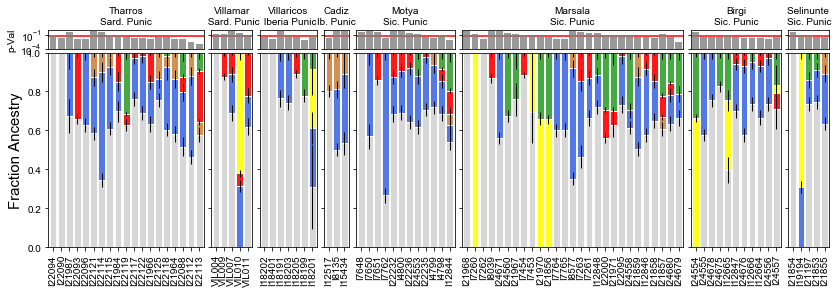

In [6]:
df1 = get_individual_models(df, min_p=0.01, feasible=True)
print(f"Loaded {len(df1)} individual best qpAdm models.")
df1 = pd.merge(df1, df_ts, left_on="t", right_on="iid", how="left")
print(f"Merged to {len(df1)} Individuals with all data")

dfs = get_dfs_from_dfq(df1, dfq, min_p=0.001,
                       labels=["Tharros", "Villamar", "Almeria", "Cadiz", 
                               "Motya", "Marsala", "Birgi", "Selinunte"])

lbl_plot = ["Tharros\nSard. Punic", "Villamar\n Sard. Punic", "Villaricos\n Iberia Punic", 
            "Cadiz\nIb. Punic", "Motya\nSic. Punic", "Marsala\nSic. Punic", "Birgi\nSic. Punic",
            "Selinunte \nSic. Punic"]

sources = ["Anatolia N", "Steppe MLBA", "WHG", 
               "Tunisia N", "Levant N", "Iran N"]
c = ["lightgray", "royalblue", "peru", "red", "yellow", "#33a02c"]

plot_qpadm_split(dfs, sources=sources, figsize=(14, 4), labels=lbl_plot,
                 bw = 0.85, lw=1,
                 c=c, ec="white", fs=10, 
                 height_ratios=[1, 10], wspace=0.08, hspace=0.03,
                 pval_lim = [1e-4, 1], pr=False, save_path="", 
                 legend=False, l_pos=(-0.25, 0.9))

### Plot Reference Populations

Loaded 193 individual best qpAdm models.
Merged to 193 Individuals with all data


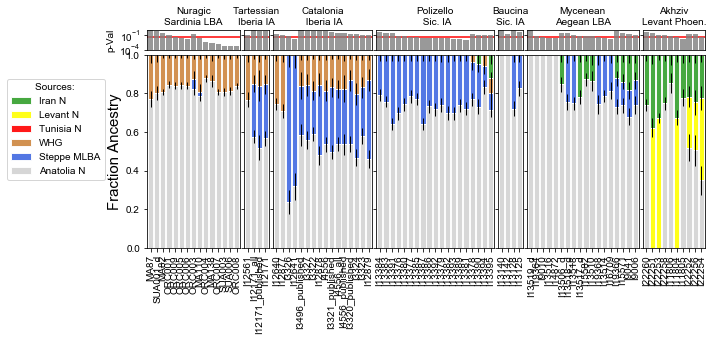

In [37]:
df1 = get_individual_models(df, min_p=0.01, feasible=True, best_p=False)
print(f"Loaded {len(df1)} individual best qpAdm models.")
df1 = pd.merge(df1, df_ts, left_on="t", right_on="iid", how="left")
print(f"Merged to {len(df1)} Individuals with all data")


dfs = get_dfs_from_dfq(df1, dfq, min_p=0.0001,
                       labels=["Sardinia", "Tartessian", "Spain IA", 
                               "Polizello", "Baucina",
                               "Mycenean", "Akhziv"])

lbl_plot = ["Nuragic\nSardinia LBA", "Tartessian\nIberia IA", "Catalonia\n Iberia IA", "Polizello\n Sic. IA", 
            "Baucina\nSic. IA", 
            "Mycenean\nAegean LBA", "Akhziv\nLevant Phoen."]

sources = ["Anatolia N", "Steppe MLBA", "WHG", 
               "Tunisia N", "Levant N", "Iran N"]
c = ["lightgray", "royalblue", "peru", "red", "yellow", "#33a02c"]

plot_qpadm_split(dfs, sources=sources, figsize=(10,4), labels=lbl_plot,
                 bw = 0.85, lw=1,
                 c=c, ec="white", fs=10, 
                 height_ratios=[1, 10], wspace=0.05, hspace=0.05,
                 pval_lim = [1e-4, 1], pr=False, save_path="", 
                 legend=True, l_pos=(-0.4, 0.9))

In [46]:
dfs[-1]

,t,p,n,s1,s2,s3,s4,s5,s6,f1,...,std5,std6,fs,iid,loc,clst,n_cov_snp,age,lat,lon
30,I22260,0.362590,2,Anatolia_N,0,0,0,0,Iran_N,0.740,...,0.000,0.032,True,I22260,"Akhziv, southern cemetery",Israel_Phoenician,611223.0,2600.0,33.049441,35.10245
37,I22251,0.234023,2,0,0,0,0,Levant_N,Iran_N,0.000,...,0.049,0.049,True,I22251,"Akhziv, southern cemetery",Israel_Phoenician,50581.0,2600.0,33.049441,35.10245
44,I22253,0.115376,2,0,0,0,0,Levant_N,Iran_N,0.000,...,0.027,0.027,True,I22253,"Akhziv, southern cemetery",Israel_Phoenician,318204.0,2600.0,33.049441,35.10245
46,I22258,0.101279,2,Anatolia_N,0,0,0,0,Iran_N,0.749,...,0.000,0.034,True,I22258,"Akhziv, southern cemetery",Israel_Phoenician,354955.0,2600.0,33.049441,35.10245
52,I11806,0.069183,2,Anatolia_N,0,0,0,0,Iran_N,0.853,...,0.000,0.052,True,I11806,"Akhziv, southern cemetery",Israel_Phoenician,102056.0,2761.0,33.049441,35.10245
65,I11804,0.033301,2,0,0,0,0,Levant_N,Iran_N,0.000,...,0.039,0.039,True,I11804,"Akhziv, southern cemetery",Israel_Phoenician,106182.0,2600.0,33.049441,35.10245
87,I11805,0.012357,2,Anatolia_N,0,0,0,0,Iran_N,0.778,...,0.000,0.044,True,I11805,"Akhziv, southern cemetery",Israel_Phoenician,197411.0,2600.0,33.049441,35.10245
123,I22252,0.140548,3,Anatolia_N,0,0,0,Levant_N,Iran_N,0.519,...,0.054,0.036,True,I22252,"Akhziv, southern cemetery",Israel_Phoenician,530692.0,2600.0,33.049441,35.10245
126,I22256,0.131403,3,Anatolia_N,0,0,0,Levant_N,Iran_N,0.504,...,0.066,0.041,True,I22256,"Akhziv, southern cemetery",Israel_Phoenician,340362.0,2600.0,33.049441,35.10245
143,I22254,0.041474,3,Anatolia_N,0,0,0,Levant_N,Iran_N,0.349,...,0.061,0.037,True,I22254,"Akhziv, southern cemetery",Israel_Phoenician,485612.0,2600.0,33.049441,35.10245


# Best p-Value

Loaded 193 individual best qpAdm models.
Merged to 193 Individuals with all data


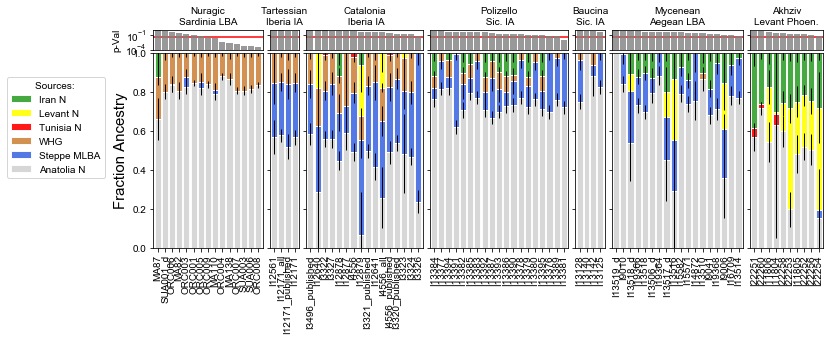

In [40]:
df1 = get_individual_models(df, min_p=0.01, feasible=True, best_p=True)
print(f"Loaded {len(df1)} individual best qpAdm models.")
df1 = pd.merge(df1, df_ts, left_on="t", right_on="iid", how="left")
print(f"Merged to {len(df1)} Individuals with all data")


dfs = get_dfs_from_dfq(df1, dfq, min_p=0.0001,
                       labels=["Sardinia", "Tartessian", "Spain IA", 
                               "Polizello", "Baucina",
                               "Mycenean", "Akhziv"])

lbl_plot = ["Nuragic\nSardinia LBA", "Tartessian\nIberia IA", "Catalonia\n Iberia IA", "Polizello\n Sic. IA", 
            "Baucina\nSic. IA", 
            "Mycenean\nAegean LBA", "Akhziv\nLevant Phoen."]

sources = ["Anatolia N", "Steppe MLBA", "WHG", 
               "Tunisia N", "Levant N", "Iran N"]
c = ["lightgray", "royalblue", "peru", "red", "yellow", "#33a02c"]

plot_qpadm_split(dfs, sources=sources, figsize=(12,4), labels=lbl_plot,
                 bw = 0.85, lw=1,
                 c=c, ec="white", fs=10, 
                 height_ratios=[1, 10], wspace=0.08, hspace=0.03,
                 pval_lim = [1e-4, 1], pr=False, save_path="", 
                 legend=True, l_pos=(-0.4, 0.9))

In [ ]:
df1["clst"].value_counts()

Loaded 193 individual best qpAdm models.
Merged to 193 Individuals with all data


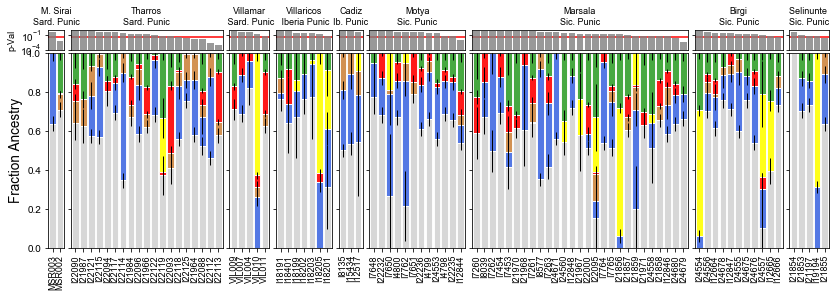

In [38]:
df1 = get_individual_models(df, min_p=0.05, feasible=True, best_p=True)
print(f"Loaded {len(df1)} individual best qpAdm models.")
df1 = pd.merge(df1, df_ts, left_on="t", right_on="iid", how="left")
print(f"Merged to {len(df1)} Individuals with all data")

dfs = get_dfs_from_dfq(df1, dfq, min_p=0.001,
                       labels=["Monte Sirai", "Tharros", "Villamar", "Almeria", "Cadiz", 
                               "Motya", "Marsala", "Birgi", "Selinunte"])

lbl_plot = ["M. Sirai\nSard. Punic", "Tharros\nSard. Punic", "Villamar\n Sard. Punic", "Villaricos\n Iberia Punic", 
            "Cadiz\nIb. Punic", "Motya\nSic. Punic", "Marsala\nSic. Punic", "Birgi\nSic. Punic",
            "Selinunte \nSic. Punic"]

sources = ["Anatolia N", "Steppe MLBA", "WHG", 
               "Tunisia N", "Levant N", "Iran N"]
c = ["lightgray", "royalblue", "peru", "red", "yellow", "#33a02c"]

plot_qpadm_split(dfs, sources=sources, figsize=(14, 4), labels=lbl_plot,
                 bw = 0.85, lw=1,
                 c=c, ec="white", fs=9, 
                 height_ratios=[1, 10], wspace=0.08, hspace=0.03,
                 pval_lim = [1e-4, 1], pr=False, save_path="", 
                 legend=False, l_pos=(-0.25, 0.9))

# Best Model with Steppe as outgroup

Found 5983/12159 models without ['Steppe_MLBA'].
Loaded 193 individual best qpAdm models.
Merged to 193 Individuals with all data


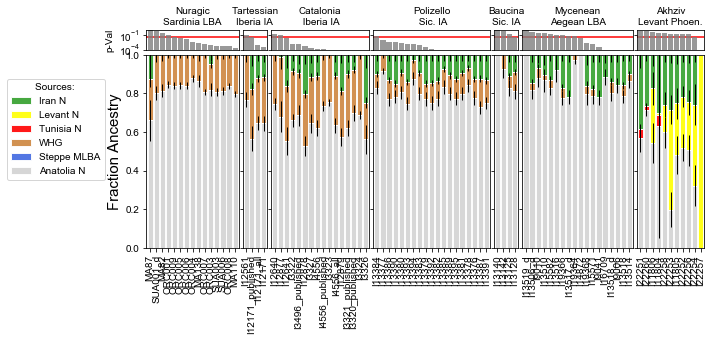

In [32]:
dft = df_excl_source(df, exclude=["Steppe_MLBA"], tot_sources=5, output=True)
df1 = get_individual_models(dft, min_p=0.01, feasible=True, best_p=True)


print(f"Loaded {len(df1)} individual best qpAdm models.")
df1 = pd.merge(df1, df_ts, left_on="t", right_on="iid", how="left")
print(f"Merged to {len(df1)} Individuals with all data")


dfs = get_dfs_from_dfq(df1, dfq, min_p=0.0,
                       labels=["Sardinia", "Tartessian", "Spain IA", 
                               "Polizello", "Baucina",
                               "Mycenean", "Akhziv"])

lbl_plot = ["Nuragic\nSardinia LBA", "Tartessian\nIberia IA", "Catalonia\n Iberia IA", "Polizello\n Sic. IA", 
            "Baucina\nSic. IA", 
            "Mycenean\nAegean LBA", "Akhziv\nLevant Phoen."]

sources = ["Anatolia N", "Steppe MLBA", "WHG", 
               "Tunisia N", "Levant N", "Iran N"]
c = ["lightgray", "royalblue", "peru", "red", "yellow", "#33a02c"]

plot_qpadm_split(dfs, sources=sources, figsize=(10,4), labels=lbl_plot,
                 bw = 0.85, lw=1,
                 c=c, ec="white", fs=10, 
                 height_ratios=[1, 10], wspace=0.05, hspace=0.05,
                 pval_lim = [1e-4, 1], pr=False, save_path="", 
                 legend=True, l_pos=(-0.4, 0.9))

Found 5983/12159 models without ['Steppe_MLBA'].
Loaded 193 individual best qpAdm models.
Merged to 193 Individuals with all data


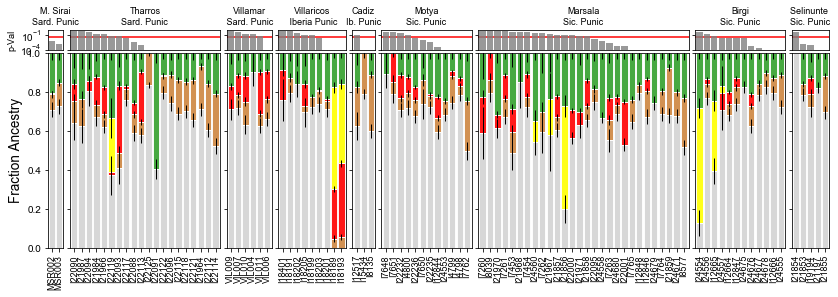

In [31]:
dft = df_excl_source(df, exclude=["Steppe_MLBA"], tot_sources=6, output=True)
df1 = get_individual_models(dft, min_p=0.05, feasible=True, best_p=True)
print(f"Loaded {len(df1)} individual best qpAdm models.")
df1 = pd.merge(df1, df_ts, left_on="t", right_on="iid", how="left")
print(f"Merged to {len(df1)} Individuals with all data")

dfs = get_dfs_from_dfq(df1, dfq, min_p=0.0,
                       labels=["Monte Sirai", "Tharros", "Villamar", "Almeria", "Cadiz", 
                               "Motya", "Marsala", "Birgi", "Selinunte"])

lbl_plot = ["M. Sirai\nSard. Punic", "Tharros\nSard. Punic", "Villamar\n Sard. Punic", "Villaricos\n Iberia Punic", 
            "Cadiz\nIb. Punic", "Motya\nSic. Punic", "Marsala\nSic. Punic", "Birgi\nSic. Punic",
            "Selinunte \nSic. Punic"]

sources = ["Anatolia N", "Steppe MLBA", "WHG", 
               "Tunisia N", "Levant N", "Iran N"]
c = ["lightgray", "royalblue", "peru", "red", "yellow", "#33a02c"]

plot_qpadm_split(dfs, sources=sources, figsize=(14, 4), labels=lbl_plot,
                 bw = 0.85, lw=1,
                 c=c, ec="white", fs=9, 
                 height_ratios=[1, 10], wspace=0.08, hspace=0.03,
                 pval_lim = [1e-4, 1], pr=False, save_path="", 
                 legend=False, l_pos=(-0.25, 0.9))

# Use Algerian IA as North African Source

In [76]:
df_ts = pd.read_csv("./output/tables/qpadm.targets.distal.v46.3.tsv", sep="\t")
print(f"Loaded {len(df_ts)} Targets")

df = pd.read_csv("./output/qpAdm/v46.3/ind_model_distAlgIA.tsv", sep="\t")
df = set_feasible_df(df, sources=6)
df.loc[df["t"] == "MA112_renamed", "t"] = "MA112"
df["t"] = df["t"].str.replace("_published", "")

dfq = pd.read_csv("./data/qpAdm_pops.tsv", sep="\t")
#df_meta = pd.read_csv("/n/groups/reich/hringbauer/Data/v46.3.anno.csv")

Loaded 194 Targets
Set 6897/12096 infeasible models


Loaded 190 individual best qpAdm models.
Merged to 190 Individuals with all data
Filtered to 149 Individuals with 100k SNPs


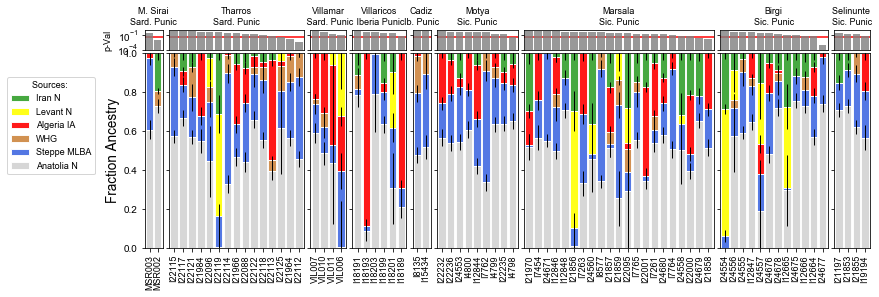

In [16]:
df1 = get_individual_models(df, min_p=0.05, feasible=True, best_p=True)
print(f"Loaded {len(df1)} individual best qpAdm models.")
df1 = pd.merge(df1, df_ts, left_on="t", right_on="iid", how="left")
print(f"Merged to {len(df1)} Individuals with all data")
df1 = df1[df1["n_cov_snp"]>1e5]
print(f"Filtered to {len(df1)} Individuals with 100k SNPs")

dfs = get_dfs_from_dfq(df1, dfq, min_p=0.0001,
                       labels=["Monte Sirai", "Tharros", "Villamar", "Almeria", "Cadiz", 
                               "Motya", "Marsala", "Birgi", "Selinunte"])

lbl_plot = ["M. Sirai\nSard. Punic", "Tharros\nSard. Punic", 
            "Villamar\n Sard. Punic", "Villaricos\n Iberia Punic", 
            "Cadiz\nIb. Punic", "Motya\nSic. Punic", 
            "Marsala\nSic. Punic", "Birgi\nSic. Punic",
            "Selinunte \nSic. Punic"]

sources = ["Anatolia N", "Steppe MLBA", "WHG", 
               "Algeria IA", "Levant N", "Iran N"]

c = ["lightgray", "royalblue", "peru", 
     "red", "yellow", "#33a02c"]

plot_qpadm_split(dfs, sources=sources, figsize=(13, 4), labels=lbl_plot,
                 bw = 0.85, lw=1,
                 c=c, ec="white", fs=9, 
                 height_ratios=[1, 10], wspace=0.08, hspace=0.03,
                 pval_lim = [1e-4, 1], pr=False, save_path="", 
                 legend=True, l_pos=(-2.5, 0.9))

Loaded 190 individual best qpAdm models.
Merged to 190 Individuals with all data
Filtered to 149 Individuals with 100k SNPs


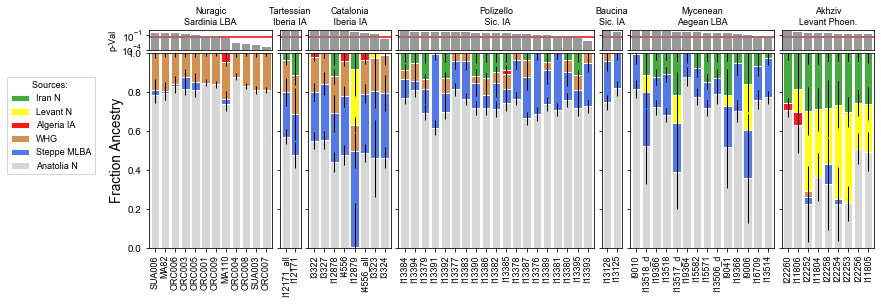

In [4]:
df1 = get_individual_models(df, min_p=0.01, feasible=True, best_p=True)
print(f"Loaded {len(df1)} individual best qpAdm models.")
df1 = pd.merge(df1, df_ts, left_on="t", right_on="iid", how="left")
print(f"Merged to {len(df1)} Individuals with all data")
df1 = df1[df1["n_cov_snp"]>1e5]
print(f"Filtered to {len(df1)} Individuals with 100k SNPs")

dfs = get_dfs_from_dfq(df1, dfq, min_p=0.0001,
                       labels=["Sardinia", "Tartessian", "Spain IA", 
                               "Polizello", "Baucina",
                               "Mycenean", "Akhziv"])

lbl_plot = ["Nuragic\nSardinia LBA", "Tartessian\nIberia IA", "Catalonia\n Iberia IA", "Polizello\n Sic. IA", 
            "Baucina\nSic. IA", 
            "Mycenean\nAegean LBA", "Akhziv\nLevant Phoen."]

sources = ["Anatolia N", "Steppe MLBA", "WHG", 
               "Algeria IA", "Levant N", "Iran N"]
c = ["lightgray", "royalblue", "peru", "red", "yellow", "#33a02c"]

plot_qpadm_split(dfs, sources=sources, figsize=(13,4), labels=lbl_plot,
                 bw = 0.85, lw=1,
                 c=c, ec="white", fs=9, 
                 height_ratios=[1, 10], wspace=0.08, hspace=0.03,
                 pval_lim = [1e-4, 1], pr=False, save_path="", 
                 legend=True, l_pos=(-0.4, 0.9))

# Show the Competitive Proximal Models

In [96]:
df_ts = pd.read_csv("./output/tables/qpadm.targets.distal.v46.3.tsv", sep="\t")
print(f"Loaded {len(df_ts)} Targets")

df = pd.read_csv("./output/qpAdm/v46.3/ind_model_comp2r.tsv", sep="\t")
df = set_feasible_df(df, sources=6) ## Add Feasibility of Model
#df.loc[df["t"] == "MA112_renamed", "t"] = "MA112"

dfq = pd.read_csv("./data/qpAdm_pops.tsv", sep="\t")
#df_meta = pd.read_csv("/n/groups/reich/hringbauer/Data/v46.3.anno.csv")

Loaded 194 Targets
Set 3643/7000 infeasible models


Loaded 125 individual best qpAdm models.
Merged to 125 Individuals with all data


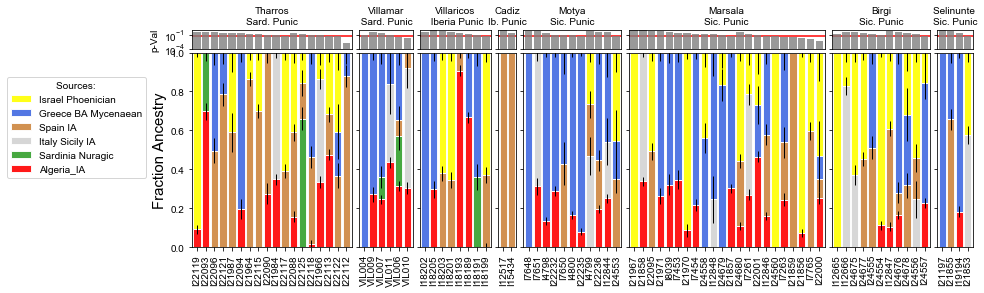

In [112]:
df1 = get_individual_models(df, min_p=0.05, feasible=True)
print(f"Loaded {len(df1)} individual best qpAdm models.")
df1 = pd.merge(df1, df_ts, left_on="t", right_on="iid", how="left")
print(f"Merged to {len(df1)} Individuals with all data")

dfs = get_dfs_from_dfq(df1, dfq, min_p=0.001,
                       labels=["Tharros", "Villamar", "Almeria", "Cadiz", 
                               "Motya", "Marsala", "Birgi", "Selinunte"])

lbl_plot = ["Tharros\nSard. Punic", "Villamar\n Sard. Punic", "Villaricos\n Iberia Punic", 
            "Cadiz\nIb. Punic", "Motya\nSic. Punic", "Marsala\nSic. Punic", "Birgi\nSic. Punic",
            "Selinunte \nSic. Punic"]
["Algeria_IA", "Italy_Sicily_IA_Polizzello", "Italy_Sardinia_BA_Nuragic", 
              "Spain_IA", "Greece_BA_Mycenaean",  "Israel_Phoenician"]


sources = ["Algeria_IA", "Sardinia Nuragic", "Italy Sicily IA", 
           "Spain IA", "Greece BA Mycenaean", "Israel Phoenician"]

c = ["red", "#33a02c", "lightgray", "peru", "royalblue", "yellow"]

plot_qpadm_split(dfs, sources=sources, figsize=(14, 4), labels=lbl_plot,
                 bw = 0.85, lw=1,
                 c=c, ec="white", fs=10, 
                 height_ratios=[1, 10], wspace=0.08, hspace=0.03,
                 pval_lim = [1e-4, 1], pr=False, save_path="", 
                 legend=True, l_pos=(-0.25, 0.9))

In [114]:
dfs[0]

,t,p,n,s1,s2,s3,s4,s5,s6,f1,...,std5,std6,fs,iid,loc,clst,n_cov_snp,age,lat,lon
23,I22119,0.391168,2,Algeria_IA,0,0,0,0,Israel_Phoenician,0.093,...,0.000,0.023,True,I22119,"Sardinia, Tharros",Italy_Sardinia_Punic_oLevant,790656.0,2225.0,39.873496,8.441024
25,I22093,0.354432,2,Algeria_IA,Italy_Sardinia_BA_Nuragic,0,0,0,0,0.698,...,0.000,0.000,True,I22093,"Sardinia, Tharros",Italy_Sardinia_Punic,55419.0,2244.0,39.873496,8.441024
29,I22096,0.316724,2,0,0,0,Spain_IA,Greece_BA_Mycenaean,0,0.000,...,0.064,0.000,True,I22096,"Sardinia, Tharros",Italy_Sardinia_Punic,436277.0,2450.0,39.873496,8.441024
32,I22121,0.286282,2,0,0,0,Spain_IA,Greece_BA_Mycenaean,0,0.000,...,0.059,0.000,True,I22121,"Sardinia, Tharros",Italy_Sardinia_Punic,764435.0,2614.0,39.873496,8.441024
34,I21987,0.275637,2,0,0,0,Spain_IA,0,Israel_Phoenician,0.000,...,0.000,0.101,True,I21987,"Sardinia, Tharros",Italy_Sardinia_Punic,42897.0,2450.0,39.873496,8.441024
39,I22094,0.219200,2,Algeria_IA,0,0,0,Greece_BA_Mycenaean,0,0.196,...,0.050,0.000,True,I22094,"Sardinia, Tharros",Italy_Sardinia_Punic_oNAfrica,43695.0,2350.0,39.873496,8.441024
43,I21964,0.169233,2,0,0,0,Spain_IA,0,Israel_Phoenician,0.000,...,0.000,0.037,True,I21964,"Sardinia, Tharros",Italy_Sardinia_Punic,768308.0,2300.0,39.873496,8.441024
51,I22115,0.113429,2,0,0,0,Spain_IA,0,Israel_Phoenician,0.000,...,0.000,0.036,True,I22115,"Sardinia, Tharros",Italy_Sardinia_Punic,782758.0,2300.0,39.873496,8.441024
58,I22090,0.096679,2,Algeria_IA,0,0,Spain_IA,0,0,0.276,...,0.000,0.000,True,I22090,"Sardinia, Tharros",Italy_Sardinia_Punic_oNAfrica,45035.0,2350.0,39.873496,8.441024
60,I21984,0.087252,2,Algeria_IA,0,Italy_Sicily_IA_Polizzello,0,0,0,0.349,...,0.000,0.000,True,I21984,"Sardinia, Tharros",Italy_Sardinia_Punic,196719.0,2300.0,39.873496,8.441024


# Show all feasible Models for 1 Individual

In [124]:
df = pd.read_csv("./output/qpAdm/v46.3/ind_model_comp2r.tsv", sep="\t")
df = set_feasible_df(df, sources=6) ## Add 
df1  = df[df["fs"]==True]

Loaded 194 Targets
Set 3643/7000 infeasible models


In [108]:
df2 = df1[df1["t"]=="I12847"]
df2 = df2[df2["p"]>0.01]
df2

,t,p,n,s1,s2,s3,s4,s5,s6,f1,...,f4,f5,f6,std1,std2,std3,std4,std5,std6,fs
2737,I12847,0.035066,3,Algeria_IA,0,0,Spain_IA,Greece_BA_Mycenaean,0,0.157,...,0.321,0.522,0.000,0.021,0.000,0.000,0.057,0.059,0.000,True
2739,I12847,0.467799,3,Algeria_IA,0,0,Spain_IA,0,Israel_Phoenician,0.105,...,0.505,0.000,0.389,0.023,0.000,0.000,0.037,0.000,0.044,True
5204,I12847,0.539818,4,Algeria_IA,0,Italy_Sicily_IA_Polizzello,Spain_IA,0,Israel_Phoenician,0.108,...,0.477,0.000,0.395,0.024,0.000,0.095,0.067,0.000,0.060,True
5211,I12847,0.324132,4,Algeria_IA,0,0,Spain_IA,Greece_BA_Mycenaean,Israel_Phoenician,0.124,...,0.412,0.199,0.265,0.028,0.000,0.000,0.064,0.154,0.122,True
5213,I12847,0.324111,4,Algeria_IA,Italy_Sardinia_BA_Nuragic,0,Spain_IA,0,Israel_Phoenician,0.106,...,0.487,0.000,0.392,0.023,0.058,0.000,0.063,0.000,0.042,True


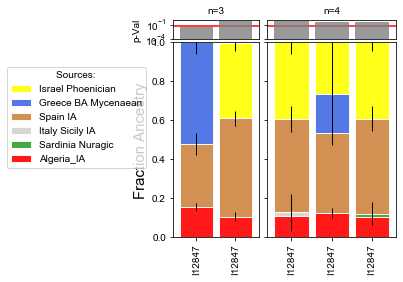

In [120]:
lbl_plot = [f"n={i}" for i in range(3,5)]
dfs = [df2[df2["n"]==i].copy() for i in range(3,5)]

sources = ["Algeria_IA", "Sardinia Nuragic", "Italy Sicily IA", 
           "Spain IA", "Greece BA Mycenaean", "Israel Phoenician"]

c = ["red", "#33a02c", "lightgray", "peru", "royalblue", "yellow"]

plot_qpadm_split(dfs, sources=sources, 
                 figsize=(4, 4), labels=lbl_plot,
                 bw = 0.85, lw=1,
                 c=c, ec="white", fs=10, 
                 height_ratios=[1, 10], wspace=0.08, hspace=0.03,
                 pval_lim = [1e-4, 1], pr=False, save_path="", 
                 legend=True, l_pos=(-0.25, 0.9))

In [132]:
df2 = df1[df1["t"]=="I22235"]
df2 = df2[df2["p"]>0.001]
df2

,t,p,n,s1,s2,s3,s4,s5,s6,f1,...,f4,f5,f6,std1,std2,std3,std4,std5,std6,fs
1562,I22235,0.028345,2,0,0,Italy_Sicily_IA_Polizzello,0,0,Israel_Phoenician,0.000,...,0.000,0.000,0.462,0.000,0.000,0.052,0.000,0.000,0.052,True
1565,I22235,0.053353,2,Algeria_IA,0,0,0,Greece_BA_Mycenaean,0,0.081,...,0.000,0.919,0.000,0.019,0.000,0.000,0.000,0.019,0.000,True
1573,I22235,0.034969,2,0,0,0,Spain_IA,0,Israel_Phoenician,0.000,...,0.414,0.000,0.586,0.000,0.000,0.000,0.040,0.000,0.040,True
3705,I22235,0.014979,3,Algeria_IA,0,Italy_Sicily_IA_Polizzello,0,Greece_BA_Mycenaean,0,0.082,...,0.000,0.902,0.000,0.020,0.000,0.138,0.000,0.143,0.000,True
3706,I22235,0.083271,3,Algeria_IA,0,Italy_Sicily_IA_Polizzello,0,0,Israel_Phoenician,0.042,...,0.000,0.000,0.392,0.022,0.000,0.052,0.000,0.000,0.060,True
3713,I22235,0.224245,3,0,0,Italy_Sicily_IA_Polizzello,Spain_IA,0,Israel_Phoenician,0.000,...,0.256,0.000,0.499,0.000,0.000,0.101,0.073,0.000,0.053,True
3716,I22235,0.014516,3,Algeria_IA,Italy_Sardinia_BA_Nuragic,0,0,Greece_BA_Mycenaean,0,0.082,...,0.000,0.916,0.000,0.019,0.050,0.000,0.000,0.055,0.000,True
3717,I22235,0.043578,3,Algeria_IA,0,0,Spain_IA,Greece_BA_Mycenaean,0,0.080,...,0.111,0.809,0.000,0.019,0.000,0.000,0.058,0.060,0.000,True
3721,I22235,0.001326,3,0,Italy_Sardinia_BA_Nuragic,0,0,Greece_BA_Mycenaean,Israel_Phoenician,0.000,...,0.000,0.489,0.352,0.000,0.088,0.000,0.000,0.230,0.153,True
3722,I22235,0.093748,3,0,0,0,Spain_IA,Greece_BA_Mycenaean,Israel_Phoenician,0.000,...,0.298,0.317,0.385,0.000,0.000,0.000,0.070,0.156,0.104,True


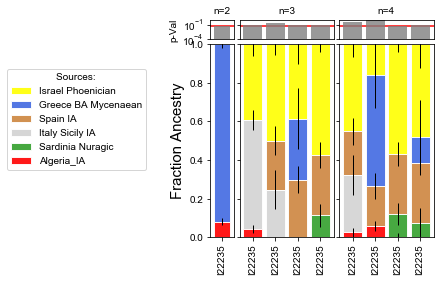

In [137]:
df2 = df1[df1["t"]=="I22235"]
df2 = df2[df2["p"]>0.05]

lbl_plot = [f"n={i}" for i in range(2,5)]
dfs = [df2[df2["n"]==i].copy() for i in range(2,5)]

sources = ["Algeria_IA", "Sardinia Nuragic", "Italy Sicily IA", 
           "Spain IA", "Greece BA Mycenaean", "Israel Phoenician"]

c = ["red", "#33a02c", "lightgray", "peru", "royalblue", "yellow"]

plot_qpadm_split(dfs, sources=sources, 
                 figsize=(4, 4), labels=lbl_plot,
                 bw = 0.85, lw=1,
                 c=c, ec="white", fs=10, 
                 height_ratios=[1, 10], wspace=0.08, hspace=0.05,
                 pval_lim = [1e-4, 1], pr=False, save_path="", 
                 legend=True, l_pos=(-2.5, 0.9))

In [142]:
df2

,t,p,n,s1,s2,s3,s4,s5,s6,f1,...,f4,f5,f6,std1,std2,std3,std4,std5,std6,fs
3725,I22236,0.022828,3,Algeria_IA,0,Italy_Sicily_IA_Polizzello,0,Greece_BA_Mycenaean,0,0.211,...,0.000,0.379,0.000,0.021,0.00,0.132,0.000,0.138,0.000,True
3728,I22236,0.010119,3,Algeria_IA,0,Italy_Sicily_IA_Polizzello,Spain_IA,0,0,0.223,...,0.170,0.000,0.000,0.020,0.00,0.069,0.068,0.000,0.000,True
3737,I22236,0.334871,3,Algeria_IA,0,0,Spain_IA,Greece_BA_Mycenaean,0,0.195,...,0.253,0.552,0.000,0.021,0.00,0.000,0.054,0.057,0.000,True
5952,I22236,0.372823,4,Algeria_IA,0,Italy_Sicily_IA_Polizzello,Spain_IA,Greece_BA_Mycenaean,0,0.201,...,0.242,0.457,0.000,0.021,0.00,0.159,0.064,0.129,0.000,True
5954,I22236,0.182586,4,Algeria_IA,0,Italy_Sicily_IA_Polizzello,Spain_IA,0,Israel_Phoenician,0.181,...,0.241,0.000,0.183,0.024,0.00,0.097,0.066,0.000,0.061,True
5962,I22236,0.167141,4,Algeria_IA,Italy_Sardinia_BA_Nuragic,0,Spain_IA,Greece_BA_Mycenaean,0,0.196,...,0.259,0.517,0.000,0.021,0.06,0.000,0.061,0.055,0.000,True


Set 3643/7000 infeasible models


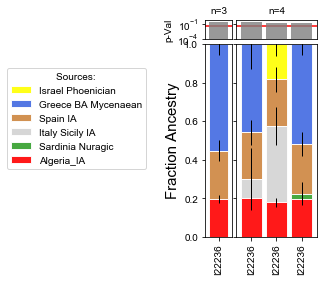

In [146]:
df = pd.read_csv("./output/qpAdm/v46.3/ind_model_comp2r.tsv", sep="\t")
df = set_feasible_df(df, sources=6) ## Add 
df1  = df[df["fs"]==True]
df2 = df1[df1["t"]=="I22236"]
df2 = df2[df2["p"]>0.05]

lbl_plot = [f"n={i}" for i in range(3,5)]
dfs = [df2[df2["n"]==i].copy() for i in range(3,5)]

sources = ["Algeria_IA", "Sardinia Nuragic", "Italy Sicily IA", 
           "Spain IA", "Greece BA Mycenaean", "Israel Phoenician"]

c = ["red", "#33a02c", "lightgray", "peru", "royalblue", "yellow"]

plot_qpadm_split(dfs, sources=sources, 
                 figsize=(2, 4), labels=lbl_plot,
                 bw = 0.85, lw=1,
                 c=c, ec="white", fs=10, 
                 height_ratios=[1, 10], wspace=0.08, hspace=0.05,
                 pval_lim = [1e-4, 1], pr=False, save_path="", 
                 legend=True, l_pos=(-2, 0.9))

# Area 51

## Test Loading of Individuals

In [81]:
def load_iids_from_indfile(path_ind, string, 
                           col="clst", col_iid="iid",
                           iids_okay=[]):
    """Load IIDs from Ind File
    Return List of IIDs"""
    df_ind = pd.read_csv(path_ind, delim_whitespace=True, header=None)
    df_ind.columns=["iid", "sex","clst"]
    idx = df_ind[col].str.contains(string)
    ls = df_ind[idx][col_iid].values
    
    ### If needed filter out okay Individuals
    if len(iids_okay)>0:
        ls = np.intersect1d(ls, iids_okay)
    return ls

def load_individuals_filetered(
                            path_anno = "/n/groups/reich/hringbauer/Data/v42.3.anno.csv",
                            col="clst", col_iid="iid",
                            min_snps_cov=50000,
                            snp_cov_col="n_cov_snp",
                            master_id_col="Master ID",
                            ):
    """Filter List of Individuals against meta,
    using minimal Nr of SNPs and unique IDs"""

    df_all = pd.read_csv(path_anno)

    ### Keep only the best coerage Indivdual
    df_all = df_all.sort_values(by=snp_cov_col, ascending=False)
    df_all = df_all.drop_duplicates(subset=master_id_col)
    
    ### Filter to min Nr of SNPs
    df_all = df_all[df_all[snp_cov_col]>=min_snps_cov]
    
    ### 
    df_all = df_all
    return df_all["iid"].values

In [82]:
### Load the ancient Individual Label Data
path_ind = "./eigenstrat/combined/punic.v46.3_ind.ind"
iids = load_individuals_filetered(path_anno='/n/groups/reich/hringbauer/Data/v46.3.anno.csv',
                                 min_snps_cov=1e5)

pops_na = ["Morocco_LN"]
pops_ib_outliers = ["Italy_Sardinia_C_o"]
pops_vil = ["Iberia_Punic_o.3rd", "Iberia_Punic_oEuropean", 
            "Iberia_Punic_o3","Iberia_Punic_oAfrican"]
pops_ibiza = ["Ibiza_Punic"]
pops_nur = ["Italy_Sardinia_BA_Nuragic"]
pops_tar = ["Iberia_Tartessian"]
pops_ib = ["Iberia_Iberian"]
pop_pol = ["Sicily_IA_Polizzello"]
pop_sic = ["Sicani"]
pops_clt =  ["Iberia_Celtiberian"]
pops_nur = ["Nuragic"]

### Add Monte Sirari and Villamar
cadir_inds = ["I12517", "I15434"]
msr_inds = ["MSR002", "MSR003"]
vil_inds = ["VIL004", "VIL006", "VIL007", 
            "VIL009", "VIL010", "VIL011"]
motya_inds= ["I4800", "I4798", "I4799",
            "I7762", "I7650", "I12844"]
birgi_inds = ["I12847", "I12665", "I12666"]
marsala_inds = ["I12846", "I12848", "I7454", "I8577"]
palermo_inds = ["I7764", "I7765"]
sources = ["Anatolia_N", "WHG", "Steppe_EMBA", "I12433"]

pops = [pops_na, pops_ib_outliers, 
        pops_clt, pops_ib, pops_tar,
        pops_nur, pops_vil, pops_ibiza]

all_iids = [[load_iids_from_indfile(path_ind=path_ind, 
                        string=pop, iids_okay=iids) for pop in ls] for ls in pops]
all_iids = [np.concatenate(ls) for ls in all_iids]
all_iids += [cadir_inds, vil_inds, msr_inds, motya_inds, birgi_inds, marsala_inds, palermo_inds]
all_iids[1] = np.append(all_iids[1], "I4246")  # Add the Spanish Outlier

paths = [[".".join([iid]+sources) for iid in ls] for ls in all_iids]
labels = ["Morocco\nLN", "CA\nOutliers",
          "Iberia IA\nCeltib.", "Iberia IA\nIberian", "Iberia IA\nTartessian",
          "Sardinia BA\nNuragic","Villaricos\nPunic", "Ibiza\nPun.", 
          "Cadir\nPunic", "Villamar\nSard. Pun.", "M. Sirai\nSard. Pun.", 
          "Motya\nSicily Pun.", "Birgi\nSic. Pun.", 
          "Marsala\nSic. Pun.", "Palermo\nSic. Pun"]

In [ ]:
all_iids